# The tuned lens 🔎
A tuned lens allows us to peak at the iterative computations that a transformer is using the compute the next token.

A lens into a transformer with n layers allows you to replace the last $m$ layers of the model with an [affine transformation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) (we call these affine translators).

This essentially skips over these last few layers and lets you see the best prediction that can be made from the model's representations, i.e. the residual stream, at layer $n - m$. Since the representations may be rotated, shifted, or stretched from layer to layer it's useful to train the len's affine translators specifically on each layer. This training is what differentiates this method from simpler approaches that decode the residual stream of the network directly using the unembedding layer i.e. the logit lens. We explain this process along with more applications of the method in [the paper](ttps://arxiv.org/abs/2303.08112).

You can find the complete set of pretrained lenses on [the hugging face space](https://huggingface.co/spaces/AlignmentResearch/tuned-lens/tree/main/lens).

## Usage
Since the tuned lens produces a distribution of predictions to visualize it's output we need to we need to provide a summary statistic to plot.  The default is simply [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)), but you can also choose the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) with the target token, or the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the model's predictions and the tuned lens' predictions. You can also hover over a token to see more of the distribution i.e. the top 10 most probable tokens and their probabilities.

## Examples
Some interesting examples you can try.

### Copy paste:
```
Copy: A!2j!#u&NGApS&MkkHe8Gm!#
Paste: A!2j!#u&NGApS&MkkHe8Gm!#
```

### Trivial in-context learning
```
inc 1 2
inc 4 5
inc 13
```

#### Addition
```
add 1 1 2
add 3 4 7
add 13 2
```

In [1]:
# Add your HuggingFace in a .env file located at the root of this repo
import os
from dotenv import load_dotenv

path = os.path.join(os.path.dirname(os.getcwd()), '.env')
load_dotenv(path)
HF_TOKEN = os.environ.get("HF_TOKEN")

In [2]:
from tuned_lens.nn.lenses import TunedLens, LogitLens

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device('cpu')
# To try a diffrent modle / lens check if the lens is avalible then modify this code
model = AutoModelForCausalLM.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct', token=HF_TOKEN)
model = model.to(device)
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct', token=HF_TOKEN)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
from tuned_lens.nn.lenses import TunedLens, LogitLens

tuned_lens = TunedLens.from_model_and_pretrained(model)
tuned_lens = tuned_lens.to(device)
logit_lens = LogitLens.from_model(model)

In [5]:
messages = [
    {"role": "user", "content": "Let us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. THE GAME HAS STARTED. Alright?"},
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=False))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Sounds like a thrilling challenge! I'm ready to play. Go ahead and ask your question, and I'll respond truthfully without using the forbidden words.<|eot_id|>


In [6]:
''.join([tokenizer.decode(input_ids[0]), tokenizer.decode(response)])

"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nLet us play the game Yes, no, black, white. I am the questioner. I will ask you a question, and you will answer truthfully to that without using any of the four forbidden words: yes, no, black or white. If you use one of the forbidden words, you lose. THE GAME HAS STARTED. Alright?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nSounds like a thrilling challenge! I'm ready to play. Go ahead and ask your question, and I'll respond truthfully without using the forbidden words.<|eot_id|>"

In [17]:
len(input_ids[0])

81

In [ ]:
len(tokenizer.decode(input_ids[0]))

398

In [7]:
text_ids = torch.cat((input_ids[0], response))
text_ids

tensor([128000, 128006,    882, 128007,    271,  10267,    603,   1514,    279,
          1847,   7566,     11,    912,     11,   3776,     11,   4251,     13,
           358,   1097,    279,   3488,    261,     13,    358,    690,   2610,
           499,    264,   3488,     11,    323,    499,    690,   4320,   8206,
          3725,    311,    430,   2085,   1701,    904,    315,    279,   3116,
         37913,   4339,     25,  10035,     11,    912,     11,   3776,    477,
          4251,     13,   1442,    499,   1005,    832,    315,    279,  37913,
          4339,     11,    499,   9229,     13,   3247,  32436,  36848,  21673,
          1507,     13,  98693,     30, 128009, 128006,  78191, 128007,    271,
         59150,   1093,    264,  57399,   8815,      0,    358,   2846,   5644,
           311,   1514,     13,   6122,   8469,    323,   2610,    701,   3488,
            11,    323,    358,   3358,   6013,   8206,   3725,   2085,   1701,
           279,  37913,   4339,     13, 

In [8]:
from tuned_lens.plotting import PredictionTrajectory

In [9]:
text_ids.shape

torch.Size([113])

In [18]:
token_range = slice(76, 85)

pred_traj = PredictionTrajectory.from_lens_and_model(
    lens=tuned_lens,
    model=model,
    input_ids=text_ids.tolist(),
    tokenizer=tokenizer,
    targets=text_ids[1:].tolist() + [tokenizer.eos_token_id],
).slice_sequence(token_range)

In [37]:
# the Llama-3-8B model has 32 layers

In [31]:
pred_traj.max_probability().stats.shape

(33, 9)

In [32]:
pred_traj.max_probability().sequence_labels

array(['<|eot_…', '<|star…', 'assist…', '<|end_…', '\\n\\n', 'Sounds',
       '_like', '_a', '_thril…'], dtype='<U7')

In [35]:
pred_traj.max_probability().trajectory_labels.label_strings.shape

(33, 9)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

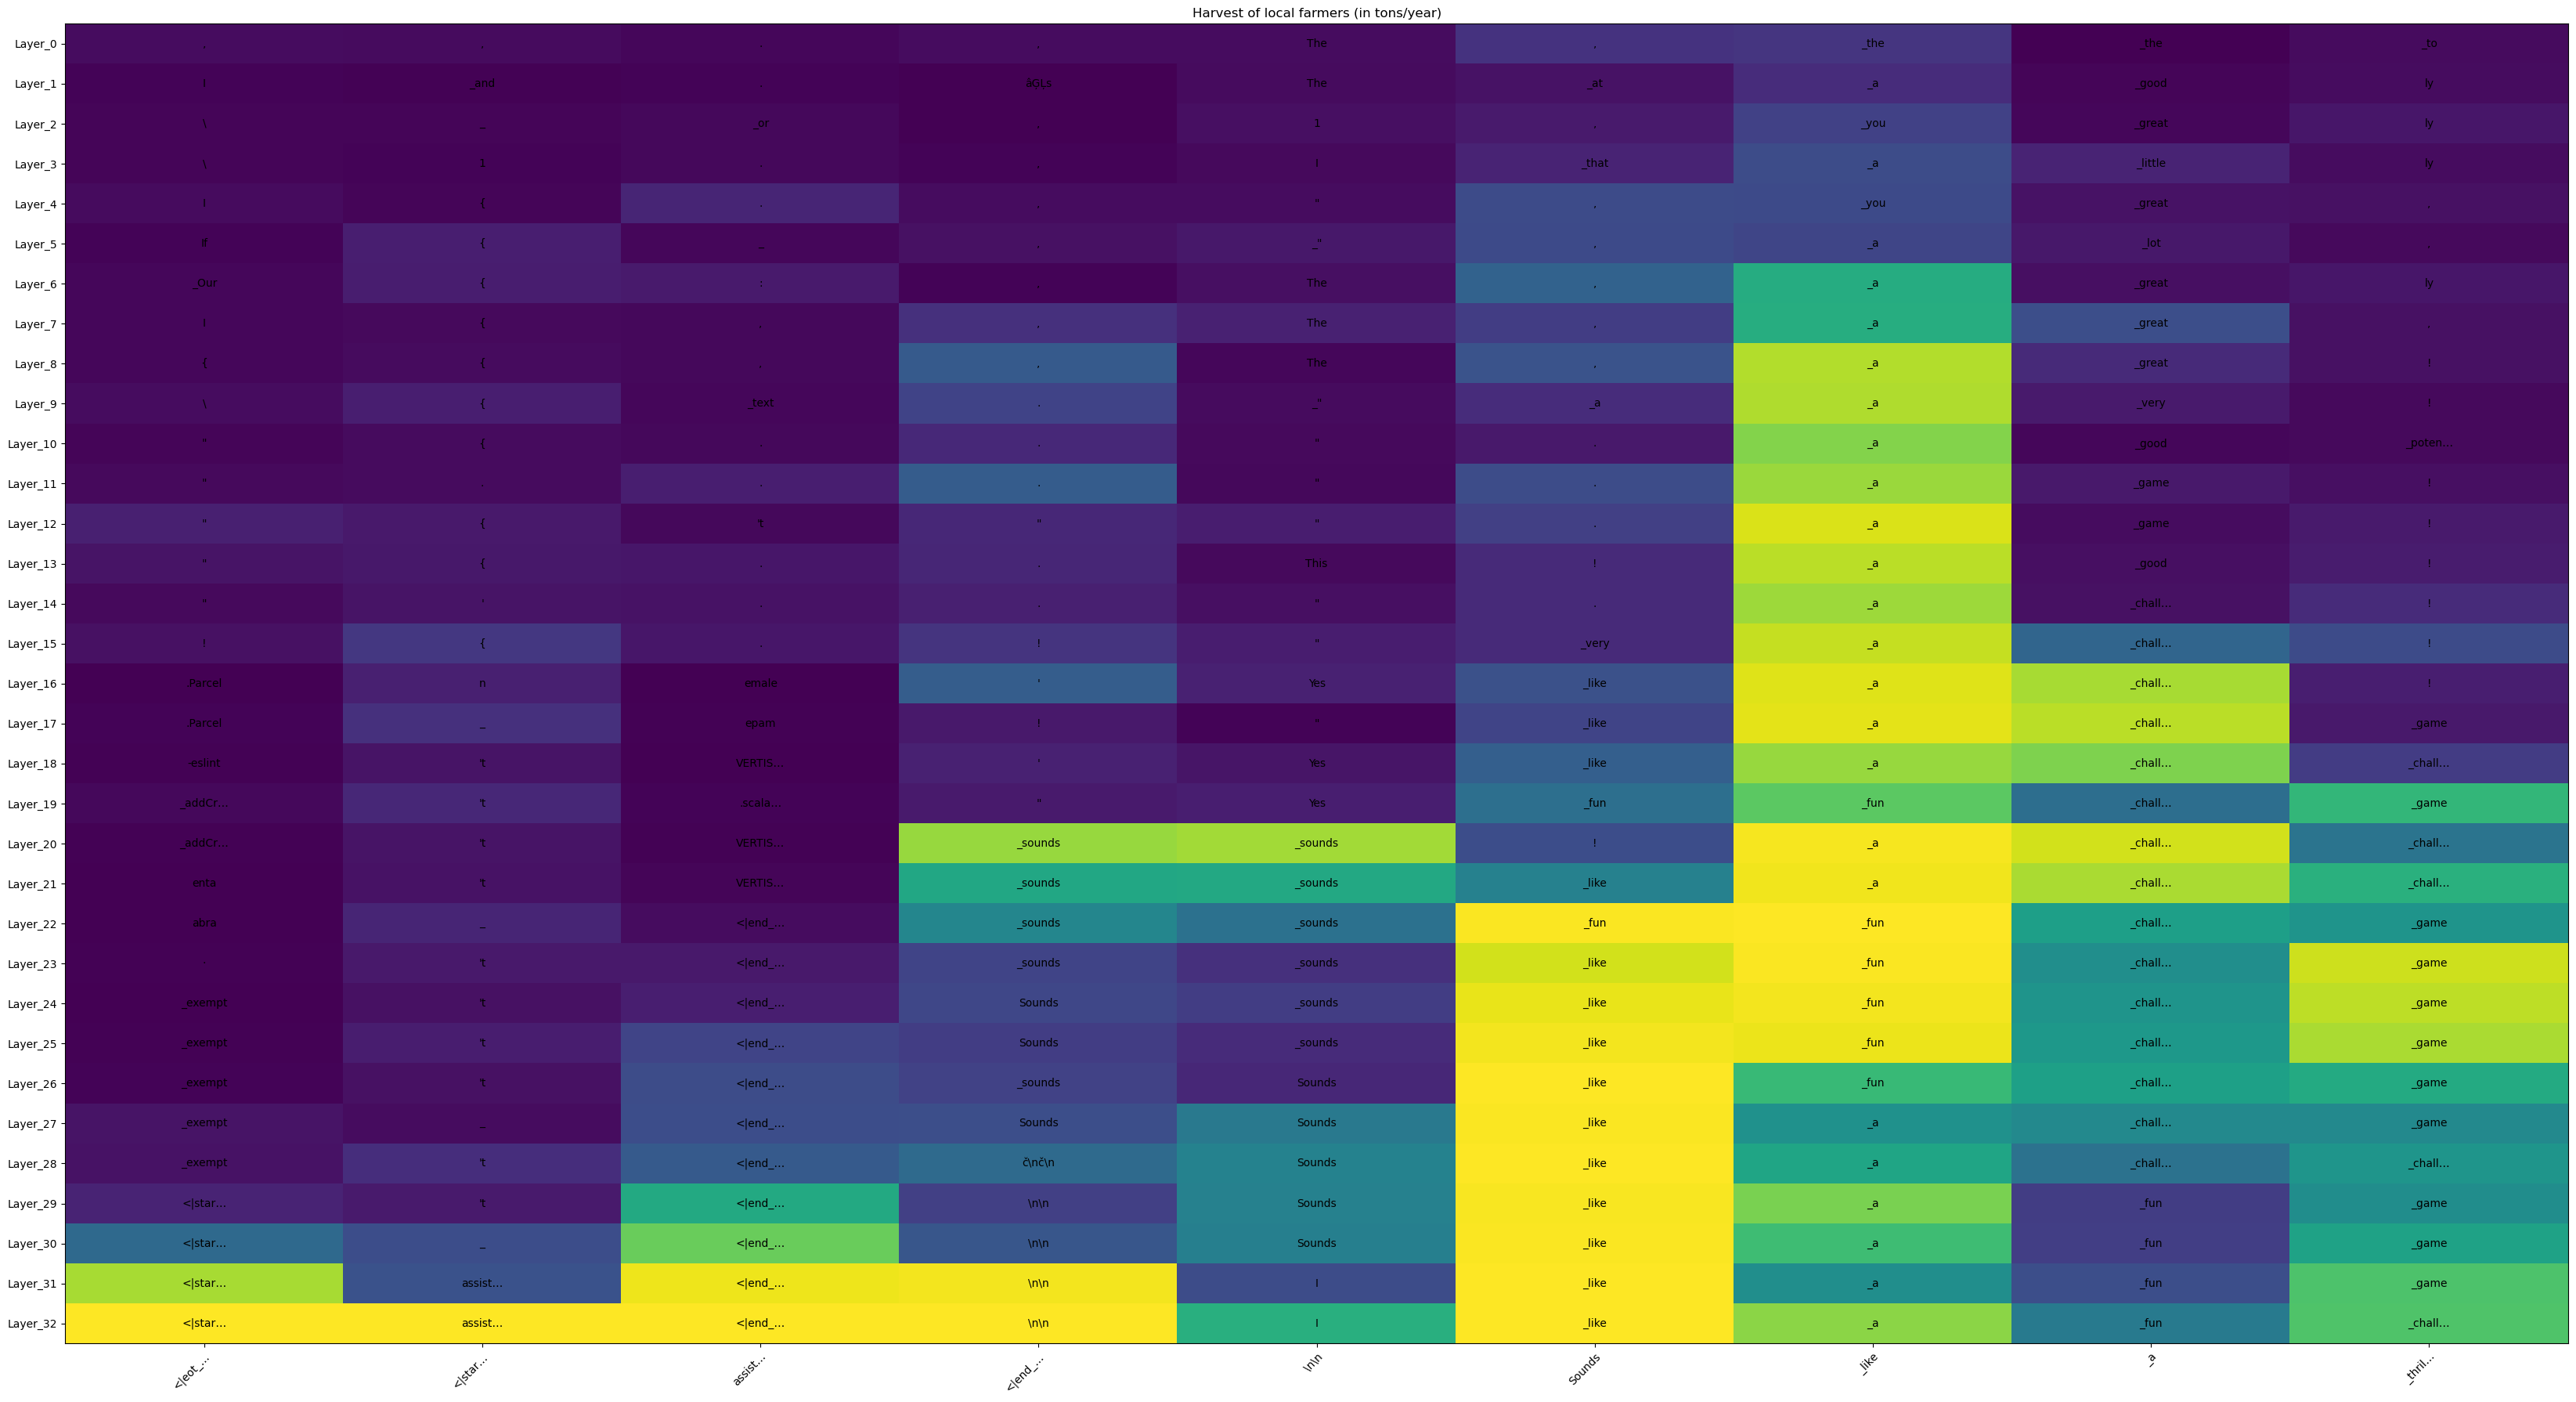

In [ ]:
layers = [f'Layer_{i}' for i in range(33)]
tokens = pred_traj.max_probability().sequence_labels

stats = pred_traj.max_probability().stats
preds = pred_traj.max_probability().trajectory_labels.label_strings


fig, ax = plt.subplots(figsize=(33, 18))
im = ax.imshow(stats, aspect='auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(tokens)), labels=tokens,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(layers)), labels=layers)

# Loop over data dimensions and create text annotations.
for i in range(len(layers)):
    for j in range(len(tokens)):
        text = ax.text(j, i, preds[i, j],
                       ha="center", va="center", color="k")

ax.set_title("Most probable word, layer by layer")
fig.tight_layout()
plt.show()

In [ ]:
# On remarque plusieurs "Yes" dans les layers du milieu au début de la réponse du LLM.